<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-08 19:15:56--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-01-08 19:15:56 (14.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

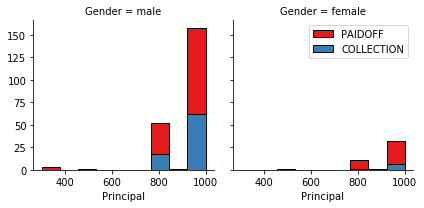

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

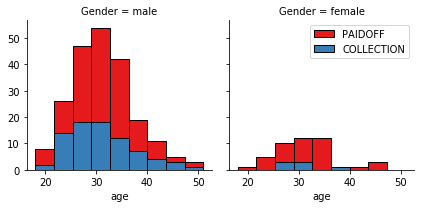

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

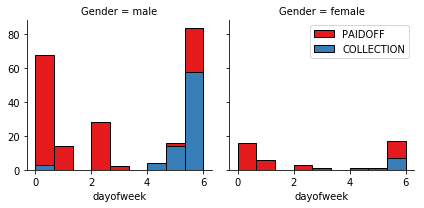

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [15]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [16]:
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [17]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Splitting Dataset to Training and Testing

First we will split the dataset to Training and Testing in order to have some point of reference before applying the model to the loan_test.csv

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Now we can just assign the respective dataset to the training and testing part of each of the Classifiers.

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [19]:
X_train_knn = X_train
X_test_knn = X_test
y_train_knn = y_train
y_test_knn = y_test

In [20]:
# Finding the best k
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

K = 20
mean_acc_knn = np.zeros((K-1))
std_acc_knn = np.zeros((K-1))
ConfustionMx_knn = [];
for i in range(1,K):
    
    #Train Model and Predict  
    kn = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2).fit(X_train_knn,y_train_knn)
    y_pred_knn=kn.predict(X_test_knn)
    mean_acc_knn[i-1] = metrics.accuracy_score(y_test_knn, y_pred_knn)

    
    std_acc_knn[i-1]=np.std(y_pred_knn == y_test_knn)/np.sqrt(y_pred_knn.shape[0])

mean_acc_knn

array([0.68965517, 0.6091954 , 0.71264368, 0.64367816, 0.73563218,
       0.66666667, 0.74712644, 0.67816092, 0.70114943, 0.68965517,
       0.79310345, 0.72413793, 0.77011494, 0.74712644, 0.77011494,
       0.75862069, 0.75862069, 0.75862069, 0.73563218])

In [21]:
# Found that best k=11 from mean_acc_knn
k_n_n = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)
k_n_n.fit(X_train_knn, y_train_knn)
y_pred_knn = k_n_n.predict(X_test_knn)

print("Train set Accuracy: ", metrics.accuracy_score(y_train_knn, k_n_n.predict(X_train_knn)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test_knn, y_pred_knn))

Train set Accuracy:  0.7722007722007722
Test set Accuracy:  0.7931034482758621


# Decision Tree

In [22]:
X_train_dt = X_train
X_test_dt = X_test
y_train_dt = y_train
y_test_dt = y_test

In [23]:
# Finding the best max_depth
from sklearn.tree import DecisionTreeClassifier

L = 20
mean_acc_dt = np.zeros((L-1))
std_acc_dt = np.zeros((L-1))
ConfustionMx_dt = [];
for i in range(1,L):
    
    #Train Model and Predict  
    dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth = i).fit(X_train_dt,y_train_dt)
    pred_tree=dec_tree.predict(X_test_dt)
    mean_acc_dt[i-1] = metrics.accuracy_score(y_test_dt, pred_tree)

    
    std_acc_dt[i-1]=np.std(pred_tree == y_test_dt)/np.sqrt(pred_tree.shape[0])

mean_acc_dt

array([0.83908046, 0.83908046, 0.83908046, 0.72413793, 0.67816092,
       0.75862069, 0.68965517, 0.72413793, 0.67816092, 0.66666667,
       0.67816092, 0.67816092, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667])

In [24]:
# Found that best max_depth=3 from mean_acc_dt
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
dec_tree.fit(X_train_dt,y_train_dt)
pred_tree=dec_tree.predict(X_test_dt)

print("DecissionTree's Accuracy: ", metrics.accuracy_score(y_test_dt, pred_tree))

DecissionTree's Accuracy:  0.8390804597701149


# Support Vector Machine

In [25]:
X_train_svm = X_train
X_test_svm = X_test
y_train_svm = y_train
y_test_svm = y_test

In [26]:
# Define a kernel SVM with RBF kernel and then try to find the best parameters and hyper-parameters values from given values
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

ksvm = SVC(kernel = 'rbf', random_state = 0)
ksvm.fit(X_train_svm, y_train_svm)

parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.5, 0.1, 0.01, 0.001, 0.0001]},
               {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.5, 0.1, 0.01, 0.001, 0.0001]}]
grid_search = GridSearchCV(estimator = ksvm,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train_svm, y_train_svm)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
best_accuracy

best_parameters

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [27]:
# Found best values are C=1, gamma = 0.1, and kernel = rbf from best_parameters
# Redefine our model with found values
ksvm = SVC(C = 1, kernel = 'rbf', gamma = 0.1, random_state = 0)
ksvm.fit(X_train_svm, y_train_svm)


y_pred_svm = ksvm.predict(X_test_svm)
y_pred_svm

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           0       0.15      0.14      0.15        14
           1       0.84      0.85      0.84        73

   micro avg       0.74      0.74      0.74        87
   macro avg       0.50      0.50      0.50        87
weighted avg       0.73      0.74      0.73        87

Confusion matrix, without normalization
[[ 2 12]
 [11 62]]


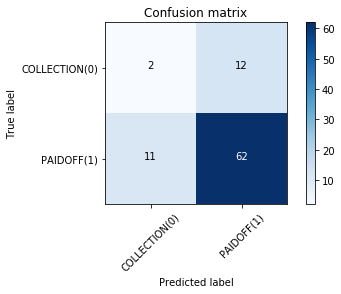

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test_svm, y_pred_svm, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test_svm, y_pred_svm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix')

# Logistic Regression

In [29]:
X_train_lr = X_train
X_test_lr = X_test
y_train_lr = y_train
y_test_lr = y_test

In [30]:
# Define logistic regression model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state = 0)
log_reg.fit(X_train_lr, y_train_lr)


y_pred_lr = log_reg.predict(X_test_lr)
y_pred_lr


y_prob_lr = log_reg.predict_proba(X_test_lr)
y_prob_lr

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[0.53, 0.47],
       [0.44, 0.56],
       [0.52, 0.48],
       [0.04, 0.96],
       [0.46, 0.54],
       [0.03, 0.97],
       [0.04, 0.96],
       [0.48, 0.52],
       [0.04, 0.96],
       [0.35, 0.65],
       [0.37, 0.63],
       [0.04, 0.96],
       [0.42, 0.58],
       [0.34, 0.66],
       [0.05, 0.95],
       [0.05, 0.95],
       [0.44, 0.56],
       [0.42, 0.58],
       [0.02, 0.98],
       [0.49, 0.51],
       [0.41, 0.59],
       [0.46, 0.54],
       [0.03, 0.97],
       [0.04, 0.96],
       [0.51, 0.49],
       [0.04, 0.96],
       [0.53, 0.47],
       [0.46, 0.54],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.52, 0.48],
       [0.05, 0.95],
       [0.05, 0.95],
       [0.05, 0.95],
       [0.42, 0.58],
       [0.45, 0.55],
       [0.44, 0.56],
       [0.03, 0.97],
       [0.04, 0.96],
       [0.05, 0.95],
       [0.45, 0.55],
       [0.46, 0.54],
       [0.03, 0.97],
       [0.35, 0.65],
       [0.5 , 0.5 ],
       [0.05, 0.95],
       [0.49, 0.51],
       [0.43,

In [31]:
# Jaccard Similarity Score
from sklearn.metrics import jaccard_similarity_score

jaccard_similarity_score(y_test_lr, y_pred_lr)

0.8160919540229885

Confusion matrix, without normalization
[[ 5  9]
 [ 7 66]]
              precision    recall  f1-score   support

           0       0.42      0.36      0.38        14
           1       0.88      0.90      0.89        73

   micro avg       0.82      0.82      0.82        87
   macro avg       0.65      0.63      0.64        87
weighted avg       0.81      0.82      0.81        87



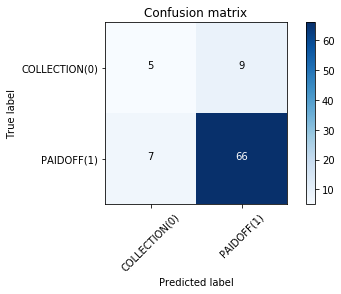

In [32]:
# Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix_lr = confusion_matrix(y_test_lr, y_pred_lr, labels=[0,1])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_lr, classes=['COLLECTION(0)','PAIDOFF(1)'],normalize= False,  title='Confusion matrix')


print (classification_report(y_test_lr, y_pred_lr))

In [33]:
#LogLoss
from sklearn.metrics import log_loss

log_loss(y_test_lr, y_prob_lr)

0.3823466316697822

# Model Evaluation using Test set

In [34]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [35]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-08 19:17:56--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-08 19:17:56 (329 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [36]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [37]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df
test_df['loan_status'].value_counts()
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
loan_test_feature = test_df[['Principal','terms','age','Gender','weekend']]
loan_test_feature = pd.concat([loan_test_feature,pd.get_dummies(test_df['education'])], axis=1)
# Avoiding the Dummy Variable Trap
loan_test_feature.drop(['Master or Above'], axis = 1,inplace=True)
loan_test_feature
test_X = loan_test_feature
test_X[0:5]
test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
test_y = test_df['loan_status'].values
test_y[0:5]

test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:23: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

### KNN Test dataset scores

In [38]:
test_X_knn = test_X
test_y_knn = test_y

y_test_pred_knn = k_n_n.predict(test_X_knn)
print("Test set Accuracy: ", metrics.accuracy_score(test_y_knn, y_test_pred_knn))

Test set Accuracy:  0.7407407407407407


In [39]:
# Jaccard Similarity
jaccard_similarity_score(test_y_knn, y_test_pred_knn)

0.7407407407407407

In [40]:
# F1 Score
f1_score(test_y_knn, y_test_pred_knn, average='weighted')

0.7144311330357843

### Decission Tree Test dataset scores

In [41]:
test_X_dt = test_X
test_y_dt = test_y

pred_tree_test=dec_tree.predict(test_X_dt)

print("DecissionTree's Accuracy: ", metrics.accuracy_score(test_y_dt, pred_tree_test))

DecissionTree's Accuracy:  0.7407407407407407


In [42]:
# Jaccard Similarity
jaccard_similarity_score(test_y_dt, pred_tree_test)

0.7407407407407407

In [43]:
# F1 Score
f1_score(test_y_dt, pred_tree_test, average='weighted')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6304176516942475

### Kernel SVM Test dataset scores

In [46]:
test_X_svm = test_X
test_y_svm = test_y

y_test_pred_svm = ksvm.predict(test_X_svm)
print("Test set Accuracy: ", metrics.accuracy_score(test_y_svm, y_test_pred_svm))

Test set Accuracy:  0.7407407407407407


In [47]:
# Jaccard Similarity
jaccard_similarity_score(test_y_svm, y_test_pred_svm)

0.7407407407407407

In [48]:
# F1 Score
f1_score(test_y_svm, y_test_pred_svm, average='weighted')

0.7144311330357843

### Logistic Regression Test dataset scores

In [49]:
test_X_lr = test_X
test_y_lr = test_y


y_test_pred_lr = log_reg.predict(test_X_lr)

y_test_prob_lr = log_reg.predict_proba(test_X_lr)

In [50]:
# Jaccard Similarity
jaccard_similarity_score(test_y_lr, y_test_pred_lr)

0.7592592592592593

In [51]:
# F1 Score
f1_score(test_y_lr, y_test_pred_lr, average='weighted')

0.6717642373556352

In [52]:
# Log Loss
log_loss(test_y_lr, y_test_prob_lr)

0.47671582180872674

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.741   | 0.714    | NA      |
| Decision Tree      | 0.741   | 0.630    | NA      |
| SVM                | 0.741   | 0.714    | NA      |
| LogisticRegression | 0.759   | 0.672    | 0.477   |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>